# Modeling

Vogel helps with iterating over multiple model forms and with analysis. This example will show a Statsmodels GLM and two forms of XgBoost trees.

In [1]:
import numpy as np
import pandas as pd
import math

import vogel.preprocessing as v_prep
import vogel.utils as v_utils
import vogel.utils.stats as v_stats
import vogel.train as v_train

import statsmodels.api as sm

## Generate Data

In [2]:
np.random.seed(42)
NumRows = 10000

data_df = pd.DataFrame({
    'id': np.array(list(range(0, NumRows))),
    'const': np.ones(NumRows),
    'EE': np.ones(NumRows),
    'StrongLinear': np.random.rand(NumRows),
    'WeakLinear': np.random.rand(NumRows),
    'Quadratic': np.random.rand(NumRows),
    'Interact_One': np.random.rand(NumRows),
    'Interact_Two': np.random.rand(NumRows),
    'Unimportant_Contin': np.random.rand(NumRows)
})
StrongCategoricalLookup = pd.DataFrame({
    'StrongCategorical':
    ["A_Medium5", "B_Medium3", "C_Low1", "v_High9", "E_Medium7", "F_Medium5"],
    'Factor': [1, .75, .5, 2, 1.25, 1]
})
WeakCategoricalLookup = pd.DataFrame({
    'WeakCategorical': ["A_medium5", "B_Medium4", "C_Medium6"],
    'Factor': [1, .95, 1.05]
})
StrongCategoricalList = [
    'A_Medium5', 'B_Medium3', 'C_Low1', 'v_High9', 'E_Medium7', 'F_Medium5'
]
WeakCategoricalList = ["A_medium5", "B_Medium4", "C_Medium6"]
UnimportantCategoricalList = ["A", "B", "C"]
data_df['StrongCategorical'] = np.random.choice(
    StrongCategoricalList, NumRows, p=[.2, .2, .1, .1, .2, .2])
data_df['WeakCategorical'] = np.random.choice(WeakCategoricalList, NumRows)
data_df['UnimportantCategorical'] = np.random.choice(
    UnimportantCategoricalList, NumRows)
data_df['TrueLogMean']\
= np.log(30) \
+ np.log(3)*data_df.StrongLinear \
+ np.log(1.05)*data_df.WeakLinear \
+ ((((data_df[['id','StrongCategorical']]).merge(StrongCategoricalLookup,on='StrongCategorical', how='left', sort=False))).Factor).apply(np.log) \
+ ((((data_df[['id','WeakCategorical']]).merge(WeakCategoricalLookup,on='WeakCategorical', how='left', sort=False))).Factor).apply(np.log) \
+ np.log(2)*data_df.Quadratic**2 \
+ np.log(.5)*data_df.Interact_One*data_df.Interact_Two

data_df['TrueMean'] = data_df.TrueLogMean.apply(np.exp)

MyP = 1.35
MyPhi = 72.65
MyMu = data_df.TrueMean

MyA = (2 - MyP) / (MyP - 1)
MyTheta = MyPhi * (MyMu ** (MyP - 1)) * (MyP - 1)
MyLambda = (MyMu * (MyP - 1)) / ((2 - MyP) * MyTheta)

data_df['Count'] = np.random.poisson(MyLambda * data_df.EE)
data_df['Loss'] = np.random.gamma(shape=data_df.Count * MyA, scale=MyTheta)
data_df['PP'] = data_df.Loss / data_df.EE
data_df['rand'] = np.random.rand(len(data_df))

print(data_df.shape)
data_df.head()

(10000, 18)


,id,const,EE,StrongLinear,WeakLinear,Quadratic,Interact_One,Interact_Two,Unimportant_Contin,StrongCategorical,WeakCategorical,UnimportantCategorical,TrueLogMean,TrueMean,Count,Loss,PP,rand
0,0,1.0,1.0,0.374540,0.373641,0.729998,0.638145,0.298912,0.847237,E_Medium7,B_Medium4,A,4.239911,69.401691,0,0.000000,0.000000,0.299212
1,1,1.0,1.0,0.950714,0.332912,0.184512,0.459292,0.094818,0.494517,F_Medium5,C_Medium6,A,4.504109,90.387759,0,0.000000,0.000000,0.790806
2,2,1.0,1.0,0.731994,0.176154,0.346640,0.964499,0.126359,0.195466,C_Low1,A_medium5,C,3.519634,33.772070,1,81.075673,81.075673,0.010721
3,3,1.0,1.0,0.598658,0.607267,0.663281,0.218978,0.180671,0.736642,B_Medium3,B_Medium4,C,4.027065,56.096038,0,0.000000,0.000000,0.304647
4,4,1.0,1.0,0.156019,0.476624,0.482089,0.587856,0.203653,0.418678,B_Medium3,B_Medium4,C,3.334992,28.078164,0,0.000000,0.000000,0.951268


# Data Filtering & Splitting

In [3]:
WEIGHT = ['EE']
TARGET = ['PP']


def train_test_split(x):
    return {'train': x[x['rand'] < 0.8], 'test': x[x['rand'] > .8]}


pipeline = v_utils.make_pipeline(
    v_prep.QueryTransformer('EE > 0 & Count < 100'),
    v_prep.FunctionTransformer(train_test_split))

samples = pipeline.fit_transform(data_df)

print('# of Rows:', len(samples['train']) + len(samples['test']))

print('Train # of Rows:', len(samples['train']))
print('Train sum EE:', samples['train'][WEIGHT].sum().values[0])

print('Test # of Rows:', len(samples['test']))
print('Test sum EE:', samples['test'][WEIGHT].sum().values[0])

train_y = pd.to_numeric(samples['train'][TARGET].iloc[:, 0])
test_y = pd.to_numeric(samples['test'][TARGET].iloc[:, 0])

train_w = pd.to_numeric(samples['train'][WEIGHT].iloc[:, 0])
test_w = pd.to_numeric(samples['test'][WEIGHT].iloc[:, 0])

# of Rows: 10000
Train # of Rows: 8067
Train sum EE: 8067.0
Test # of Rows: 1933
Test sum EE: 1933.0


In [4]:
feature_groups = {
    'interactions': ['Interact_One', 'Interact_Two'],
    'unimportant': ['Unimportant_Contin', 'UnimportantCategorical']
}

In [9]:
FEATURES = [
    'unimportant', 'interactions', 'StrongLinear', 'Quadratic',
    'WeakCategorical', 'StrongCategorical'
]

pipeline = v_utils.make_pipeline(
    v_prep.FeatureUnion([
        ('numeric',
         v_utils.make_pipeline(
             v_prep.ColumnExtractor(
                 FEATURES, feature_groups, want_numeric=True),
             v_prep.NullEncoder(), 
             v_prep.Imputer(),
             v_prep.Binning(
                 bin_id='mean',
                 bins=30,
                 feature_filter=['StrongLinear'],
                 drop='replace'))),
        ('cats',
         v_utils.make_pipeline(
             v_prep.ColumnExtractor(
                 FEATURES, feature_groups, want_numeric=False),
             v_prep.LabelEncoder())),
    ]))

train_X = pipeline.fit_transform(samples['train'])
test_X = pipeline.transform(samples['test'])
train_X.head()

,Unimportant_Contin,Interact_One,Interact_Two,Quadratic,StrongLinear_q_g30,UnimportantCategorical__A,UnimportantCategorical__C,WeakCategorical__B_Medium4,WeakCategorical__C_Medium6,StrongCategorical__E_Medium7,StrongCategorical__F_Medium5,StrongCategorical__B_Medium3,StrongCategorical__v_High9,StrongCategorical__C_Low1
0,0.847237,0.638145,0.298912,0.729998,0.376784,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.494517,0.459292,0.094818,0.184512,0.948527,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,0.195466,0.964499,0.126359,0.346640,0.740016,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.736642,0.218978,0.180671,0.663281,0.605984,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.594627,0.700210,0.242262,0.738571,0.146172,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
v_prep.Binning?

In [12]:
run_list = [{
    'model_type': v_train.V_SM_GLM,
    'model_name': 'simple' + '_SM_LinReg_tweedie',
    'model_params': {
        'custom_weight': train_w,
        'family': sm.families.Tweedie(var_power=1.5)
    },
    'fit_params': {
        'maxiter': 10
    }
}, {
    'model_type': v_train.V_xgb,
    'model_name': 'simple' + '_xgb',
    'model_params': {
        'objective': 'reg:linear',
        'n_estimators': 80,
        'learning_rate': .1,
        'n_jobs': -1
    },
    'fit_params': {
        'sample_weight': train_w,
        'eval_set': [(train_X, train_y), (test_X, test_y)],
        'verbose': False
    }
}]

train_data_dict = {'X': train_X, 'y': train_y, 'w': train_w}
test_data_dict = {'X': test_X, 'y': test_y, 'w': test_w}

model_runner = v_train.ModelRunner('tweedie', run_list, train_data_dict,
                                   test_data_dict, pipeline)

cl_eval_stand = model_runner.evaluate_models()
cl_eval_stand

,rmse,mae,gini,tweedie_deviance,hl_tweedie,model_name,model_dict,set,weighted_rmse
0,144.552374,91.058747,0.302431,237833.026606,0.124393,simple_SM_LinReg_tweedie,{'model_type': <class 'vogel.train.train.V_SM_...,train,NaN
1,146.869128,91.401731,0.274236,14313.936087,0.042554,simple_SM_LinReg_tweedie,{'model_type': <class 'vogel.train.train.V_SM_...,valid,146.869128
2,139.406676,88.609811,0.391809,242076.637190,0.382275,simple_xgb,{'model_type': <class 'vogel.train.train.V_xgb...,train,NaN
3,147.738357,91.832364,0.248623,572807.012325,0.091981,simple_xgb,{'model_type': <class 'vogel.train.train.V_xgb...,valid,147.738357


In [13]:
run_list = [{
    'model_type': v_train.V_SM_GLM,
    'model_name': 'simple' + '_SM_LinReg_tweedie',
    'model_params': {
        'custom_weight': train_w,
        'family': sm.families.Tweedie(var_power=1.5)
    },
    'fit_params': {
        'maxiter': 10
    }
}, {
    'model_type': v_train.V_xgb,
    'model_name': 'simple' + '_xgb_tweedie',
    'model_params': {
        'objective': 'reg:tweedie',
        'n_estimators': 80,
        'learning_rate': .1,
        'n_jobs': -1
    },
    'fit_params': {
        'sample_weight': train_w,
        'eval_set': [(train_X, train_y), (test_X, test_y)],
        'verbose': False,
        'eval_metric': 'rmse'
    }
}, {
    'model_type': v_train.V_xgb,
    'model_name': 'simple' + '_xgb',
    'model_params': {
        'objective': 'reg:linear',
        'n_estimators': 80,
        'learning_rate': .1,
        'n_jobs': -1
    },
    'fit_params': {
        'sample_weight': train_w,
        'eval_set': [(train_X, train_y), (test_X, test_y)],
        'verbose': False,
        'eval_metric': 'rmse'
    }
}]

train_data_dict = {'X': train_X, 'y': train_y, 'w': train_w}
test_data_dict = {'X': test_X, 'y': test_y, 'w': test_w}

model_runner = v_train.ModelRunner('tweedie', run_list, train_data_dict,
                                   test_data_dict, pipeline)

eval_stats = model_runner.evaluate_models()
eval_stats

,rmse,mae,gini,tweedie_deviance,hl_tweedie,model_name,model_dict,set,weighted_rmse
0,144.552374,91.058747,0.302431,237833.026606,0.124393,simple_SM_LinReg_tweedie,{'model_type': <class 'vogel.train.train.V_SM_...,train,NaN
1,146.869128,91.401731,0.274236,14313.936087,0.042554,simple_SM_LinReg_tweedie,{'model_type': <class 'vogel.train.train.V_SM_...,valid,146.869128
2,141.017606,87.274554,0.396924,240585.409951,0.435974,simple_xgb_tweedie,{'model_type': <class 'vogel.train.train.V_xgb...,train,NaN
3,147.920711,90.035790,0.252412,62681.226592,0.173057,simple_xgb_tweedie,{'model_type': <class 'vogel.train.train.V_xgb...,valid,147.920711
4,139.406676,88.609811,0.391809,242076.637190,0.382275,simple_xgb,{'model_type': <class 'vogel.train.train.V_xgb...,train,NaN
5,147.738357,91.832364,0.248623,572807.012325,0.091981,simple_xgb,{'model_type': <class 'vogel.train.train.V_xgb...,valid,147.738357


In [14]:
v_stats.plot_compare_stats(eval_stats, valiv_only=False)

TypeError: plot_compare_stats() got an unexpected keyword argument 'valiv_only'

simple_SM_LinReg_tweedie
Valid Hosmer–Lemeshow


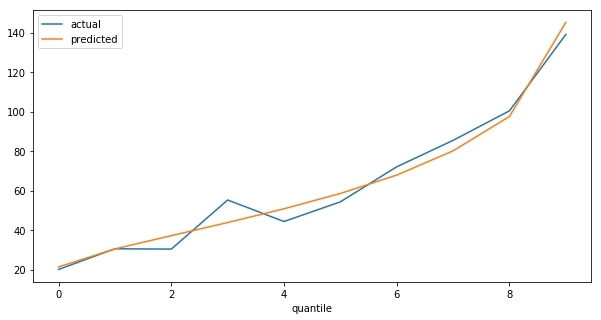

simple_xgb_tweedie
Valid Hosmer–Lemeshow


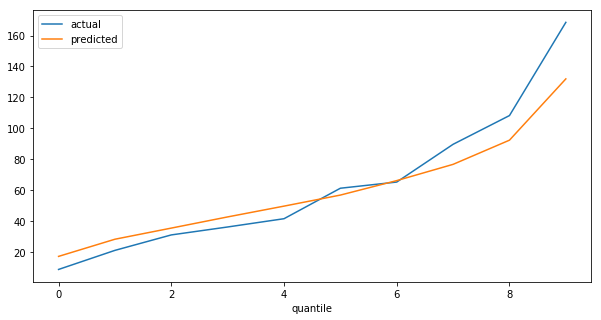

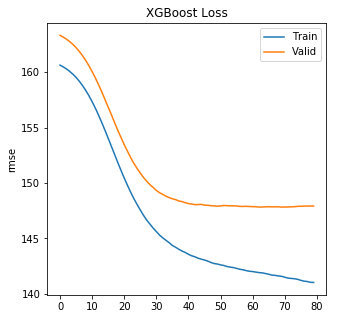

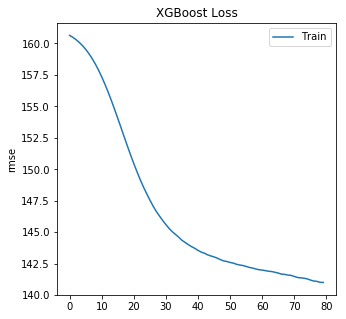

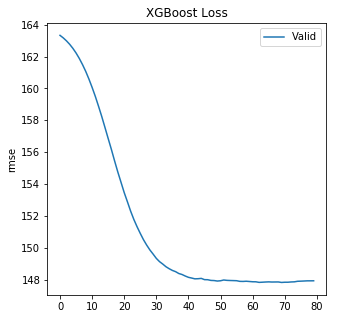

simple_xgb
Valid Hosmer–Lemeshow


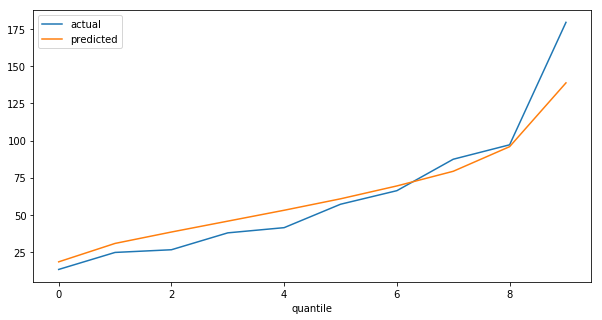

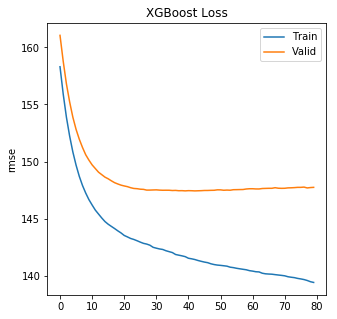

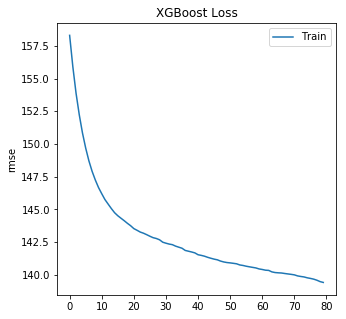

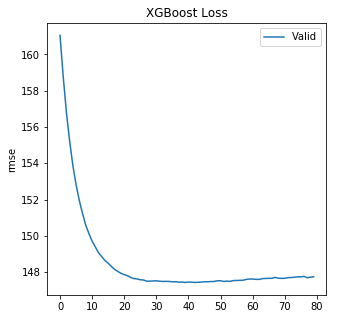

In [15]:
model_runner.plot_models()

In [16]:
sm_mdl = model_runner.models[0]
sm_mdl.model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                  GLM                  AIC:                nan        
Link Function:          log                  BIC:                182270.4019
Dependent Variable:     y                    Log-Likelihood:     nan        
Date:                   2018-09-06 01:38     LL-Null:            nan        
No. Observations:       8067                 Deviance:           2.5470e+05 
Df Model:               14                   Pearson chi2:       3.18e+05   
Df Residuals:           8052                 Scale:              39.554     
Method:                 IRLS                                                
----------------------------------------------------------------------------
                              Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
const                         3.4825   0.1266 27.5105 0.0000  3.2344  3.7306
Unimportant_Contin           -0.0603   0.0876 -0.6889 0.4909 -0.2319  0.1113
Interact_One                 -0.3124   0.0880 -3.5505 0.0004 -0.4848 -0.1399
Interact_Two                 -0.3245   0.0877 -3.6993 0.0002 -0.4965 -0.1526
Quadratic                     0.7931   0.0887  8.9444 0.0000  0.6193  0.9668
StrongLinear_q_g30            1.1778   0.0885 13.3143 0.0000  1.0044  1.3512
UnimportantCategorical__A    -0.0201   0.0619 -0.3249 0.7453 -0.1413  0.1011
UnimportantCategorical__C    -0.0304   0.0620 -0.4893 0.6246 -0.1519  0.0912
WeakCategorical__B_Medium4   -0.0309   0.0618 -0.5008 0.6165 -0.1520  0.0901
WeakCategorical__C_Medium6    0.0403   0.0618  0.6521 0.5143 -0.0808  0.1614
StrongCategorical__E_Medium7  0.0906   0.0776  1.1669 0.2433 -0.0616  0.2428
StrongCategorical__F_Medium5 -0.0977   0.0794 -1.2301 0.2187 -0.2534  0.0580
StrongCategorical__B_Medium3 -0.4193   0.0834 -5.0283 0.0000 -0.5828 -0.2559
StrongCategorical__v_High9    0.5742   0.0875  6.5659 0.0000  0.4028  0.7456
StrongCategorical__C_Low1    -0.7803   0.1099 -7.1022 0.0000 -0.9956 -0.5649
============================================================================

"""

UnimportantCategorical


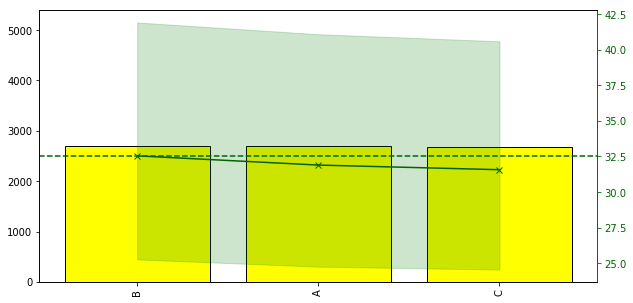

WeakCategorical


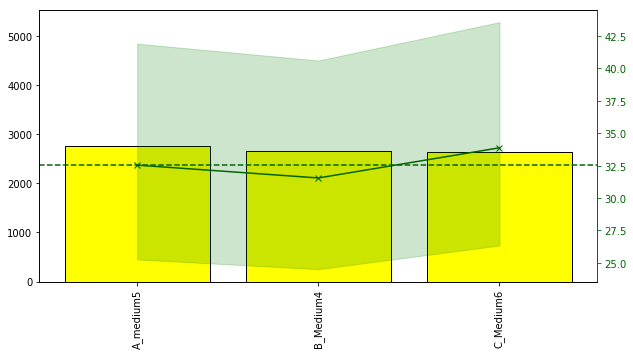

StrongCategorical


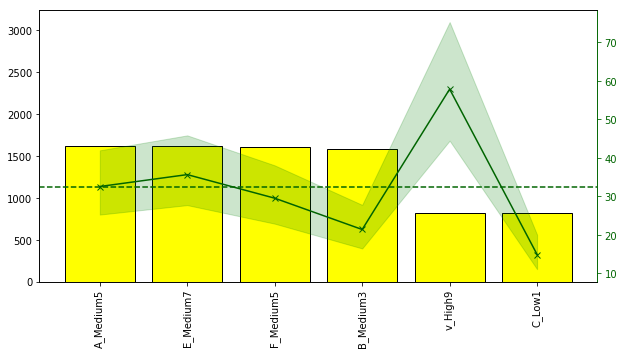

In [17]:
sm_mdl.plot_glm_one_way_fit()

UnimportantCategorical


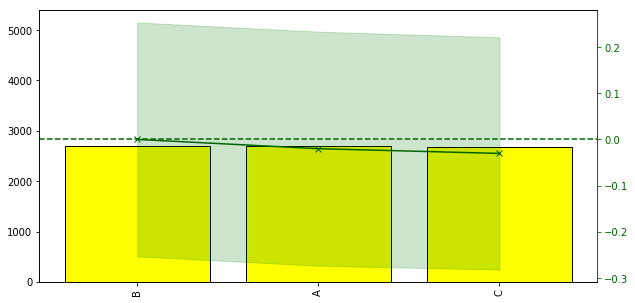

WeakCategorical


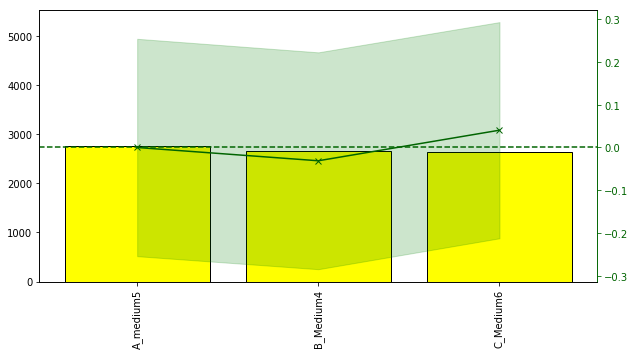

StrongCategorical


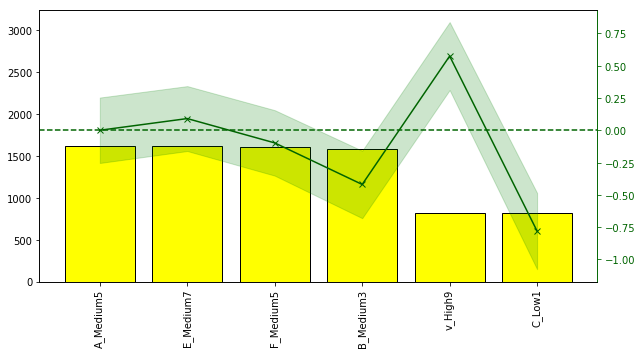

In [23]:
sm_mdl.plot_glm_one_way_fit(predicted_value=False, scale_to_zero=True)

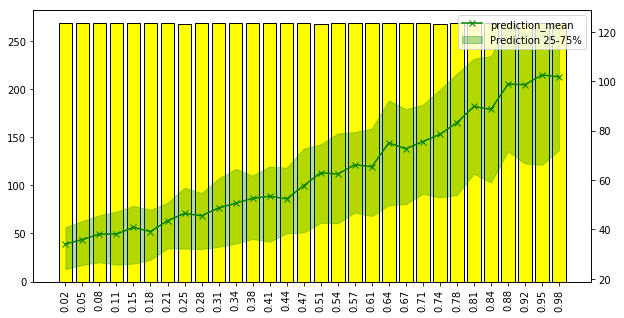

In [24]:
v_stats.plot_one_way_fit(train_X['StrongLinear_q_g30'],
                         sm_mdl.predict(train_X))

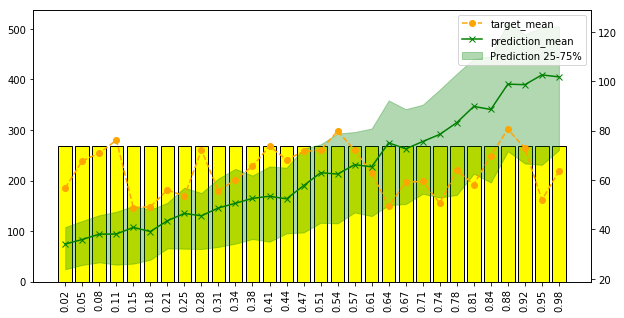

In [26]:
v_stats.plot_one_way_fit(train_X['StrongLinear_q_g30'],
                         sm_mdl.predict(train_X),
                         target=train_y,
#                          objective='median',
#                          error='std',
#                          target_error=True,
                         pad_bar_chart=True
                        )

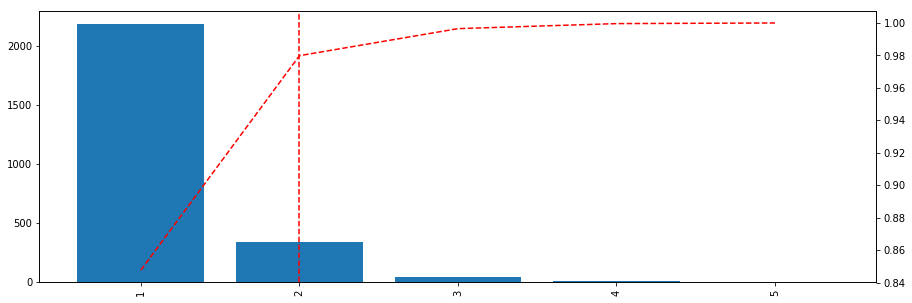

In [27]:
temp = data_df[['Count', 'Loss']][data_df['Loss'] > 0].groupby('Count').agg(
    ['count', 'mean'])
temp
v_stats.plot_pareto(
    temp['Loss']['count'].values,
    temp['Loss']['count'].index,
    numeric=True,
    cutoff=.99)

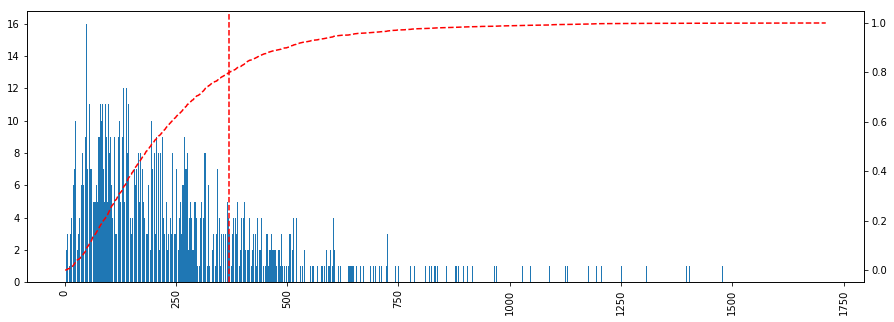

In [28]:
temp = data_df.copy()
temp['PP'] = np.round(temp['PP'], 0)
temp = temp[['PP',
             'Loss']][temp['Loss'] > 0].groupby('PP').agg(['count', 'mean'])
temp
v_stats.plot_pareto(
    temp['Loss']['count'].values,
    temp['Loss']['count'].index,
    numeric=True,
    cutoff=.8)

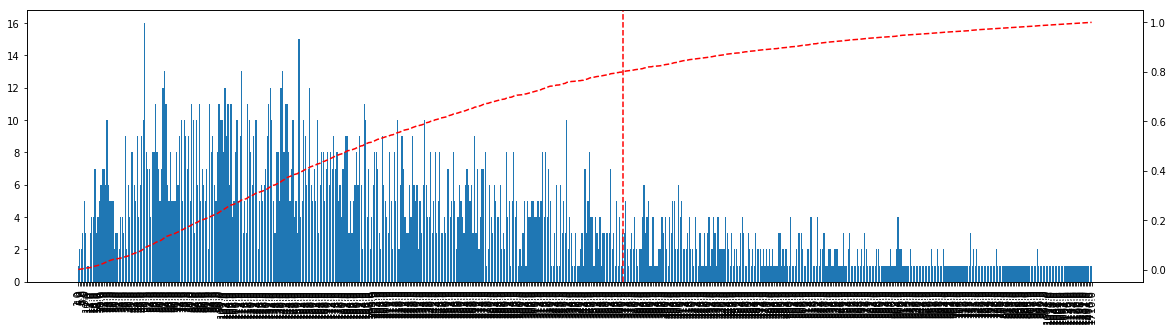

In [29]:
temp = data_df.copy()
temp['PP'] = np.round(temp['PP'], 0)
temp = temp[['PP',
             'Loss']][temp['Loss'] > 0].groupby('PP').agg(['count', 'mean'])
temp
v_stats.plot_pareto(
    temp['Loss']['count'].values,
    temp['Loss']['count'].index,
    numeric=False,
    cutoff=.8,
    plt_size=(20,5)
)